In [ ]:
   from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, DepthwiseConv1D, SeparableConv1D, DepthwiseConv2D, SeparableConv2D, Conv2D, Conv2DTranspose, Lambda, Input, concatenate
from tensorflow.keras.layers import Layer, Conv1D, Concatenate, Input
from tensorflow.keras.models import Sequential
import open3d as o3d
import os
from scipy.spatial import KDTree
from keras import backend as K
import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.regularizers import Regularizer
from scipy.stats import wasserstein_distance

In [ ]:
import open3d as o3d
import numpy as np
import os, cv2

images_data, pc_data, m_depth_data, depth_data = [], [], [], []
clouds_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Meshs 3D'))
images_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Fastener Images'))
m_depth_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Monocular Depth'))
depth_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Fastener Depth'))

for PC, iimage, M_Depth in zip(clouds_dir, images_dir, m_depth_dir):
  image = cv2.imread(f'/content/drive/MyDrive/Mesh Generated Data/Fastener Images/{iimage}')
  image = cv2.resize(image, (256, 256))
  image = (image-image.min())/(image.max()-image.min())
  m_depth = cv2.imread(f'/content/drive/MyDrive/Mesh Generated Data/Monocular Depth/{M_Depth}')
  m_depth = cv2.resize(m_depth, (256, 256))
  m_depth = (m_depth-m_depth.min())/(m_depth.max()-m_depth.min())
  mesh = o3d.io.read_triangle_mesh(f'/content/drive/MyDrive/Mesh Generated Data/Meshs 3D/{PC}')
  vertices = o3d.utility.Vector3dVector(mesh.vertices)
  vertices_array = np.asarray(vertices)
  images_data.append(image)
  pc_data.append(vertices_array)
  m_depth_data.append(m_depth)

def pad_point_clouds(point_clouds):
    # Find the maximum number of points among all point clouds
    max_num_points = max(len(pc) for pc in point_clouds)
    padded_point_clouds = []
    # Pad each point cloud to the maximum size
    for pc in point_clouds:
        num_points_to_pad = max_num_points - len(pc)
        padded_pc = np.pad(pc, ((0, num_points_to_pad), (0, 0)), mode='constant', constant_values=0)
        padded_point_clouds.append(padded_pc)
    return padded_point_clouds

pc_data = pad_point_clouds(pc_data)
MESHEs = np.array(pc_data)
IMAGEs = np.array(images_data)
M_DEPTHs = np.array(m_depth_data)

MESHEs.shape, IMAGEs.shape, M_DEPTHs.shape

((29, 25056, 3), (29, 256, 256, 3), (29, 256, 256, 3))

In [ ]:
# train_data=tf.data.Dataset.from_tensor_slices((tf.cast(IMAGEs,tf.float32), tf.cast(MESHEs,tf.float32), tf.cast(M_DEPTHs,tf.float32)))
# # test_data=tf.data.Dataset.from_tensor_slices((tf.cast(IMAGEs[22:],tf.float32), tf.cast(MESHEs[:22],tf.float32), tf.cast(M_DEPTHs[22:],tf.float32))).batch(1)
# train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(25056, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

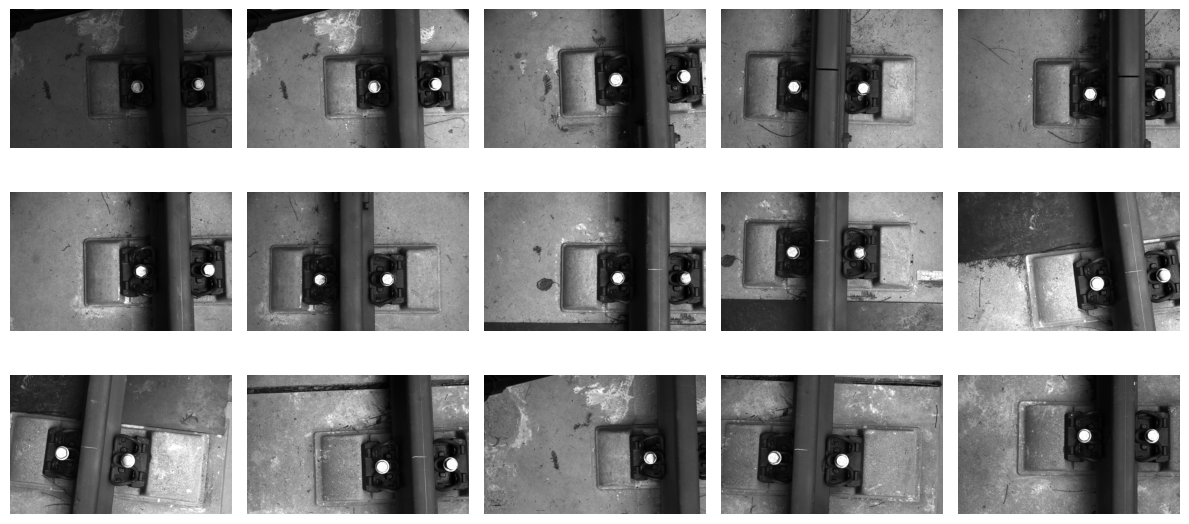

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 5, figsize=(12, 6))

# Turn off axis labels and ticks
for ax in axs.flatten():
    ax.axis('off')

# Plot the images
for i in range(15):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(IMAGEs[i])

# Show the plot
plt.tight_layout()
plt.savefig('images_fig.png', dpi=300)
plt.show()


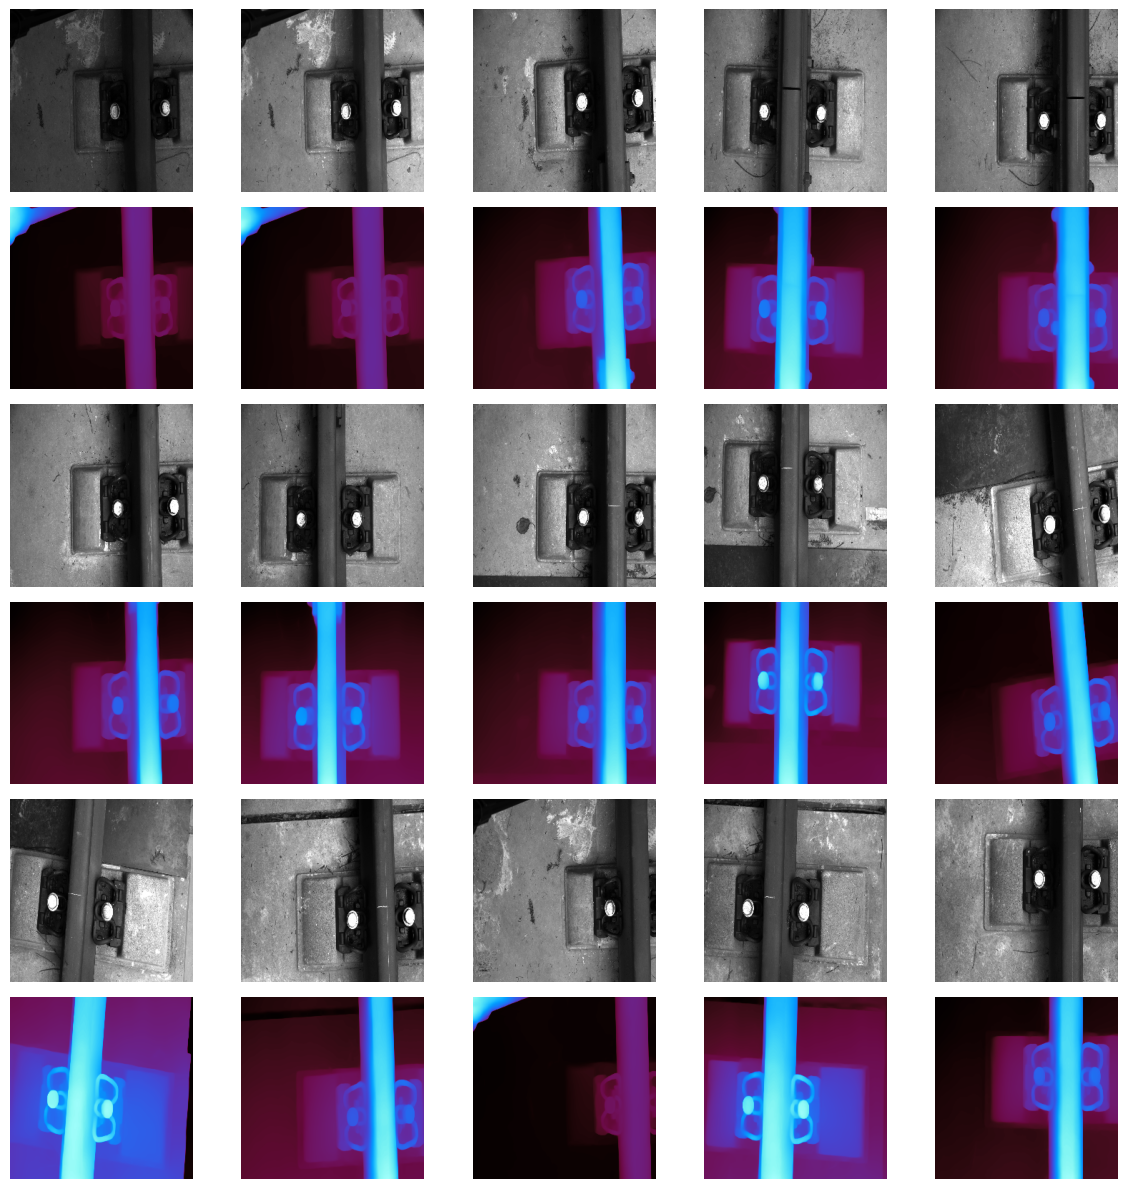

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 5, figsize=(12, 12))

# Turn off axis labels and ticks
for ax in axs.flatten():
    ax.axis('off')

# Plot the images and corresponding depths
for i in range(5):
    if i < len(IMAGEs):  # Check if there are enough images
        axs[0, i].imshow(IMAGEs[i])
        # axs[0, i].set_title('RGB Image')
    if i < len(M_DEPTHs):  # Check if there are enough depths
        axs[1, i].imshow(M_DEPTHs[i])
        # axs[1, i].set_title('Monocular Depth')
    if i+5 < len(IMAGEs):  # For the second set of images
        axs[2, i].imshow(IMAGEs[i+5])
        # axs[2, i].set_title('RGB Image')
    if i+5 < len(M_DEPTHs):  # For the second set of depths
        axs[3, i].imshow(M_DEPTHs[i+5])
        # axs[3, i].set_title('Monocular Depth')
    if i+10 < len(IMAGEs):  # For the third set of images
        axs[4, i].imshow(IMAGEs[i+10])
        # axs[4, i].set_title('RGB Image')
    if i+10 < len(M_DEPTHs):  # For the third set of depths
        axs[5, i].imshow(M_DEPTHs[i+10])
        # axs[5, i].set_title('Monocular Depth')

# Show the plot
plt.tight_layout()
plt.savefig('DATAFIGs.png', dpi=300)
plt.show()


## Generative Adverserial Network

In [ ]:
import tensorflow as tf

def downsample_Image(filters, size, apply_batchnorm=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same'))  # Downsample by half
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

def upsample_Image(filters, size, apply_dropout=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=1, padding='same'))  # Upsample to original size
    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())
    return model

def downsample_m(filters, size, apply_batchnorm=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters, size, strides=1, padding='same'))  # Downsample by half
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

def upsample_m(filters, size, apply_dropout=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1DTranspose(filters, size, strides=1, padding='same'))  # Upsample to original size
    model.add(tf.keras.layers.UpSampling1D(2))
    model.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())
    return model

def downsample_d(filters, size, apply_batchnorm=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same'))  # Downsample by half
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

def upsample_d(filters, size, apply_dropout=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=1, padding='same'))  # Upsample to original size
    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())
    return model

def unified_generator(input_shape_image, input_shape_mesh, input_shape_depth):
    # Image generator block
    image_inputs = tf.keras.layers.Input(shape=input_shape_image)
    x_image = image_inputs

    down_stack_image = [
        downsample_Image(8, 4, apply_batchnorm=False), #64->8, 128->16, 256->32, 512->64
        downsample_Image(16, 4),
        downsample_Image(32, 4),
        downsample_Image(64, 4),
        downsample_Image(64, 4),
    ]

    up_stack_image = [
        upsample_Image(64, 4, apply_dropout=True),
        upsample_Image(64, 4, apply_dropout=True),
        upsample_Image(32, 4),
        upsample_Image(16, 4),
        upsample_Image(8, 4),
    ]

    for down in down_stack_image:
        x_image = down(x_image)

    for up in up_stack_image:
        x_image = up(x_image)

    last_image = tf.keras.layers.Conv2D(3, 4, strides=1, padding='same', activation='tanh')
    x_image = last_image(x_image)

    # Mesh generator block
    mesh_inputs = tf.keras.layers.Input(shape=input_shape_mesh)
    x_mesh = mesh_inputs

    down_stack_mesh = [
        downsample_m(8, 4, apply_batchnorm=False),  #64->8, 128->16, 256->32, 512->64
        downsample_m(16, 4),
        downsample_m(32, 4),
        downsample_m(64, 4),
        downsample_m(64, 4),
    ]

    up_stack_mesh = [
        upsample_m(64, 4, apply_dropout=True),
        upsample_m(64, 4, apply_dropout=True),
        upsample_m(32, 4),
        upsample_m(16, 4),
        upsample_m(8, 4),
    ]

    for down in down_stack_mesh:
        x_mesh = down(x_mesh)

    for up in up_stack_mesh:
        x_mesh = up(x_mesh)

    last_mesh = tf.keras.layers.Conv1DTranspose(3, 4, strides=1, padding='same', activation='tanh')
    x_mesh = last_mesh(x_mesh)

    # Depth generator block
    depth_inputs = tf.keras.layers.Input(shape=input_shape_depth)
    x_depth = depth_inputs

    down_stack_depth = [
        downsample_d(8, 4, apply_batchnorm=False), #64->8, 128->16, 256->32, 512->64
        downsample_d(16, 4),
        downsample_d(32, 4),
        downsample_d(64, 4),
        downsample_d(64, 4),
    ]

    up_stack_depth = [
        upsample_d(64, 4, apply_dropout=True),
        upsample_d(64, 4, apply_dropout=True),
        upsample_d(32, 4),
        upsample_d(16, 4),
        upsample_d(8, 4),
    ]

    for down in down_stack_depth:
        x_depth = down(x_depth)

    for up in up_stack_depth:
        x_depth = up(x_depth)

    last_depth = tf.keras.layers.Conv2D(3, 4, strides=1, padding='same', activation='sigmoid')
    x_depth = last_depth(x_depth)

    return tf.keras.Model(inputs=[image_inputs, mesh_inputs, depth_inputs], outputs=[x_image, x_mesh, x_depth])

# Example usage
unified_gen = unified_generator((256, 256, 3), (25056, 3), (256, 256, 3))
unified_gen.summary()


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_53            │ (None, 25056, 3)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_64            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_39             │ (None, 128, 128, 8)    │            392 │ input_layer_42[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_49             │ (None, 12528, 8)       │            104 │ input_layer_53[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_59             │ (None, 128, 128, 8)    │            392 │ input_layer_64[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_40             │ (None, 64, 64, 16)     │          2,128 │ sequential_39[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_50             │ (None, 6264, 16)       │            592 │ sequential_49[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_60             │ (None, 64, 64, 16)     │          2,128 │ sequential_59[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_41             │ (None, 32, 32, 32)     │          8,352 │ sequential_40[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_51             │ (None, 3132, 32)       │          2,208 │ sequential_50[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_61             │ (None, 32, 32, 32)     │          8,352 │ sequential_60[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_42             │ (None, 16, 16, 64)     │         33,088 │ sequential_41[0][0]    │
│ (Sequential)              │                        │                │                        │
├──────────────────────

 Total params: 643,065 (2.45 MB)

 Trainable params: 640,905 (2.44 MB)

 Non-trainable params: 2,160 (8.44 KB)

In [ ]:
unified_gen([tf.random.uniform((1, 256, 256, 3)), tf.random.uniform((1, 25056, 3)), tf.random.uniform((1, 256, 256, 3))])

[<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[-2.9944177e-04,  1.5648066e-03,  1.2033833e-03],
          [-1.0591934e-03,  2.0741532e-03,  1.0999395e-03],
          [-1.2851498e-03,  1.7559017e-03,  4.5700002e-04],
          ...,
          [-2.4723695e-03,  4.7228229e-04,  1.7334183e-03],
          [ 5.3415808e-04, -1.2321442e-03,  6.4451480e-04],
          [-2.4323957e-04, -5.9253594e-05, -2.0721371e-03]],
 
         [[-9.7359862e-04,  1.5737457e-03,  1.4551899e-03],
          [-1.7360179e-03,  2.8357555e-03,  7.4129936e-04],
          [-2.2216463e-03,  3.3254053e-03, -4.5740974e-04],
          ...,
          [-8.5773654e-03,  3.3497219e-03,  1.2714851e-03],
          [-5.0989487e-03,  1.4709693e-03,  1.0056967e-03],
          [-4.9574003e-03,  2.0520550e-03, -1.9456916e-03]],
 
         [[-8.0472109e-04,  1.8555189e-03,  1.5570570e-03],
          [-1.6760807e-03,  1.9111724e-03,  4.4855051e-04],
          [-2.4836289e-03,  1.9787634e-03, -4.2672968e-05],
     

In [ ]:
def Discriminator_combined(image_shape, mesh_shape, depth_shape):
    # Initialize the input layers for images, meshes, and depths
    image_input = tf.keras.layers.Input(shape=image_shape, name='input_image')
    mesh_input = tf.keras.layers.Input(shape=mesh_shape, name='input_mesh')
    depth_input = tf.keras.layers.Input(shape=depth_shape, name='input_depth')

    # Process image input
    x_img = downsample_Image(4, 4)(image_input)
    x_img = downsample_Image(8, 4)(x_img)
    x_img = downsample_Image(16, 4)(x_img)
    x_img = tf.keras.layers.Flatten()(x_img)  # Flatten the image output

    # Process depth input
    x_depth = downsample_Image(4, 4)(depth_input)
    x_depth = downsample_Image(8, 4)(x_depth)
    x_depth = downsample_Image(16, 4)(x_depth)
    x_depth = tf.keras.layers.Flatten()(x_depth)  # Flatten the depth output

    # Flatten the mesh input
    x_mesh = downsample_m(2, 4)(mesh_input)
    x_mesh = downsample_m(4, 4)(x_mesh)
    x_mesh = downsample_m(8, 4)(x_mesh)


    # Concatenate the processed outputs
    x = tf.keras.layers.Flatten()(x_img)
    y = tf.keras.layers.Flatten()(x_depth)
    z = tf.keras.layers.Flatten()(x_mesh)

    # Further processing
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(8, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)

    y = tf.keras.layers.Dense(16, activation='relu')(y)
    y= tf.keras.layers.Dense(8, activation='relu')(y)
    y = tf.keras.layers.Dense(1)(y)

    z = tf.keras.layers.Dense(16, activation='relu')(z)
    z = tf.keras.layers.Dense(8, activation='relu')(z)
    z = tf.keras.layers.Dense(1)(z)

    return tf.keras.Model(inputs=[image_input, mesh_input, depth_input], outputs=[x,y,z])

# Example usage
discriminator_combined = Discriminator_combined((256, 256, 3), (25056, 3), (256, 256, 3))
discriminator_combined.summary()


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_depth (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_69             │ (None, 128, 128, 4)    │            212 │ input_image[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_72             │ (None, 128, 128, 4)    │            212 │ input_depth[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_mesh (InputLayer)   │ (None, 25056, 3)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_70             │ (None, 64, 64, 8)      │            552 │ sequential_69[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_73             │ (None, 64, 64, 8)      │            552 │ sequential_72[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_75             │ (None, 12528, 2)       │             34 │ input_mesh[0][0]       │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_71             │ (None, 32, 32, 16)     │          2,128 │ sequential_70[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_74             │ (None, 32, 32, 16)     │          2,128 │ sequential_73[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_76             │ (None, 6264, 4)        │             52 │ sequential_75[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 16384)          │              0 │ sequential_71[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 16384)          │              0 │ sequential_74[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_77             │ (None, 3132, 8)        │            168 │ sequential_76[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 16384)          │              0 │ flatten_5[0][0]        │
├──────────────────────

 Total params: 931,705 (3.55 MB)

 Trainable params: 931,565 (3.55 MB)

 Non-trainable params: 140 (560.00 B)

In [ ]:
import tensorflow as tf

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [ ]:
@tf.function
def train_step(real_images, real_meshes, real_depths):
    noise = tf.random.normal([batch_size, 256, 256, 3])  # Adjust this based on input shape

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images, generated_meshes, generated_depths = unified_gen([real_images, real_meshes, real_depths], training=True)

        # Get the outputs from the discriminator
        real_output = discriminator_combined([real_images, real_meshes, real_depths], training=True)
        fake_output = discriminator_combined([generated_images, generated_meshes, generated_depths], training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output[0])  # Use the output corresponding to images
        disc_loss = discriminator_loss(real_output[0], fake_output[0])  # Use the output corresponding to images

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, unified_gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_combined.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, unified_gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_combined.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
real_images.shape
real_meshes.shape
real_depths.shape

TensorShape([29, 256, 256, 3])

In [ ]:
@tf.function
def test_step(real_images, real_meshes, real_depths):
    # Generate images, meshes, and depths without training mode
    generated_images, generated_meshes, generated_depths = unified_gen([real_images, real_meshes, real_depths], training=False)

    # Get the outputs from the discriminator without training mode
    real_output = discriminator_combined([real_images, real_meshes, real_depths], training=False)
    fake_output = discriminator_combined([generated_images, generated_meshes, generated_depths], training=False)

    # Calculate losses for evaluation purposes
    test_gen_loss = generator_loss(fake_output[0])  # Use the output corresponding to images
    test_disc_loss = discriminator_loss(real_output[0], fake_output[0])  # Use the output corresponding to images

    return generated_images, generated_meshes, generated_depths, test_gen_loss, test_disc_loss


In [ ]:
# num_epochs = 10
# batch_size = 32  # Adjust this based on your dataset

# # Assuming you have a tf.data.Dataset object called `dataset`
# for epoch in range(num_epochs):
#     for real_images, real_meshes, real_depths in train_data.batch(batch_size):  # Use your dataset
#         gen_loss, disc_loss = train_step(real_images, real_meshes, real_depths)

#     print(f'Epoch: {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')


Epoch: 1, Gen Loss: 6.88787841796875, Disc Loss: 0.011911939829587936
Epoch: 2, Gen Loss: 6.571380138397217, Disc Loss: 0.01917796954512596
Epoch: 3, Gen Loss: 7.678410530090332, Disc Loss: 0.014643143862485886
Epoch: 4, Gen Loss: 7.923540115356445, Disc Loss: 0.011970246210694313
Epoch: 5, Gen Loss: 8.499105453491211, Disc Loss: 0.010586244985461235
Epoch: 6, Gen Loss: 6.681663513183594, Disc Loss: 0.015031249262392521
Epoch: 7, Gen Loss: 6.954813003540039, Disc Loss: 0.011146793141961098
Epoch: 8, Gen Loss: 5.70084285736084, Disc Loss: 0.01860877498984337
Epoch: 9, Gen Loss: 6.617214202880859, Disc Loss: 0.02244890108704567
Epoch: 10, Gen Loss: 8.655147552490234, Disc Loss: 0.013591459020972252


In [ ]:
import tensorflow as tf

# Assuming IMAGEs, MESHEs, and M_DEPTHs are your data arrays
data_size = len(IMAGEs)  # Get the total number of samples
split_index = int(data_size * 0.8)  # Calculate the split index for 80%

# Create the full dataset
full_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(IMAGEs, tf.float32),
    tf.cast(MESHEs, tf.float32),
    tf.cast(M_DEPTHs, tf.float32)
))

# Split into training and testing datasets
train_data = full_dataset.take(split_index)  # First 80%
test_data = full_dataset.skip(split_index)    # Last 20%

# Define the number of epochs and batch size
num_epochs = 10
batch_size = 32  # Adjust this based on your dataset

# Training loop
for epoch in range(num_epochs):
    for real_images, real_meshes, real_depths in train_data.batch(batch_size):
        gen_loss, disc_loss = train_step(real_images, real_meshes, real_depths)

    print(f'Epoch: {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')

# Testing loop
# Testing loop
for real_images, real_meshes, real_depths in test_data.batch(batch_size):
    generated_images, generated_meshes, generated_depths, test_gen_loss, test_disc_loss = test_step(real_images, real_meshes, real_depths)

    # Print or log evaluation metrics
    print(f'Test Gen Loss: {test_gen_loss.numpy()}, Test Disc Loss: {test_disc_loss.numpy()}')

    # Add your evaluation metrics here
    # For example, you might calculate loss or accuracy on the test set


Epoch: 1, Gen Loss: 6.680327892303467, Disc Loss: 0.02357439510524273
Epoch: 2, Gen Loss: 6.889081954956055, Disc Loss: 0.020262200385332108
Epoch: 3, Gen Loss: 6.6389055252075195, Disc Loss: 0.01884436048567295
Epoch: 4, Gen Loss: 6.763678550720215, Disc Loss: 0.0163411982357502
Epoch: 5, Gen Loss: 6.292044639587402, Disc Loss: 0.025412799790501595
Epoch: 6, Gen Loss: 6.974205017089844, Disc Loss: 0.016626356169581413
Epoch: 7, Gen Loss: 7.3221635818481445, Disc Loss: 0.015699997544288635
Epoch: 8, Gen Loss: 7.412617206573486, Disc Loss: 0.014144571498036385
Epoch: 9, Gen Loss: 7.409977436065674, Disc Loss: 0.014749448746442795
Epoch: 10, Gen Loss: 6.9445343017578125, Disc Loss: 0.012202903628349304
Test Gen Loss: 0.6801397800445557, Test Disc Loss: 1.3882192373275757


In [ ]:
# Testing loop
# Testing loop
for real_images, real_meshes, real_depths in test_data.batch(batch_size):
    generated_images, generated_meshes, generated_depths, test_gen_loss, test_disc_loss = test_step(real_images, real_meshes, real_depths)

    # Print or log evaluation metrics
    print(f'Test Gen Loss: {test_gen_loss.numpy()}, Test Disc Loss: {test_disc_loss.numpy()}')

    # Add your evaluation metrics here

NameError: name 'test_data' is not defined

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_images(real_image, generated_image):
    return ssim(real_image, generated_image, multichannel=True), psnr(real_image, generated_image)


In [ ]:
def estimate_mesh_tightness(mesh):
    # Example: Average distance between vertices
    distances = []
    for i in range(len(mesh)):
        for j in range(i + 1, len(mesh)):
            distance = np.linalg.norm(mesh[i] - mesh[j])
            distances.append(distance)
    return 1 / np.mean(distances) if distances else 0


In [ ]:
def analyze_depth_images(real_depth, generated_depth):
    depth_diff = np.abs(real_depth - generated_depth)
    mean_depth_diff = np.mean(depth_diff)
    return mean_depth_diff  # Lower values indicate better performance


In [ ]:
for real_images, real_meshes, real_depths in test_data.batch(batch_size):
    generated_images, generated_meshes, generated_depths, test_gen_loss, test_disc_loss = test_step(real_images, real_meshes, real_depths)

    # Evaluate images
    image_scores = [evaluate_images(real_images[i], generated_images[i]) for i in range(len(real_images))]

    # Evaluate meshes
    mesh_scores = [estimate_mesh_tightness(generated_meshes[i]) for i in range(len(generated_meshes))]

    # Evaluate depth images
    depth_scores = [analyze_depth_images(real_depths[i], generated_depths[i]) for i in range(len(real_depths))]

    # Print scores for analysis
    print(f'Image Scores (SSIM, PSNR): {image_scores}')
    print(f'Mesh Tightness Scores: {mesh_scores}')
    print(f'Depth Image Differences: {depth_scores}')


NameError: name 'test_data' is not defined

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


def Discriminator_Image():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')


  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample_Image(64, 4)(x)  # (batch_size, 128, 128, 64)

  down2 = downsample_Image(128, 4)(down1)  # (batch_size, 64, 64, 128)

  down3 = downsample_Image(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

## Testing Visulization


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random noise input
random_input = np.random.normal(size=(1, 128, 128, 3))

# Generate an image
generated_image = Genrator_ImageDepth(random_input)

# Plotting the generated image
plt.imshow((generated_image[0].numpy() + 1) / 2)  # Scale the image to [0, 1]
plt.axis('off')
plt.show()

NameError: name 'Genrator_ImageDepth' is not defined

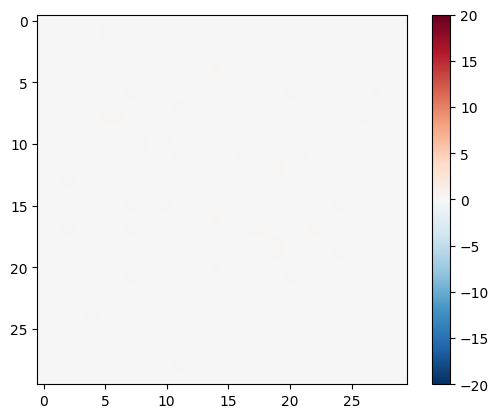

In [ ]:
disc_out = discriminator([tf.random.uniform((1,256,256,3)),tf.random.uniform((1,256,256,3))])
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator= Genrator_ImageDepth,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
def fit(train_ds, test_ds, steps):
  exampl/*-- e_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      /-checkpoint.save(file_prefix=checkpoint_prefix)

SyntaxError: invalid syntax (<ipython-input-25-6a8ecc0b46fc>, line 2)

In [ ]:
fit(train_data,test_data, steps=4000)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
images = [...]  # List of your images (NumPy arrays)
tightness_scores = [...]  # List of scores for each image (e.g., [score1, score2, ...])

# Assuming each score corresponds to different parts of the image
part_scores = {
    "Part 1": [0.7, 0.8, 0.9],  # Replace with actual part scores for each image
    "Part 2": [0.6, 0.7, 0.85],
    # Add more parts as necessary
}

# Plotting
num_images = len(images)
plt.figure(figsize=(15, 5 * num_images))

for i in range(num_images):
    plt.subplot(num_images, 1, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')

    # Draw lines and annotate scores for each part
    for j, (part, scores) in enumerate(part_scores.items()):
        # Example coordinates for where to draw lines (you may want to adjust these)
        start_point = (10, 10 + j * 20)  # Example starting point
        end_point = (150, 10 + j * 20)    # Example ending point

        # Draw the line
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'r-', lw=2)

        # Annotate the score
        plt.text(end_point[0] + 5, end_point[1], f'{part}: {scores[i]:.2f}', fontsize=12, color='red')

plt.tight_layout()
plt.show()
